In [71]:
!pip install missingno
!pip install statsmodels
!pip install imbalanced-learn
!pip install scikeras

In [72]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing and imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Data visualization
import missingno as msno

# Machine learning models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Neural Networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

# SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# Define file paths for other datasets
processed_cleveland_data_path = '/content/drive/My Drive/ML A1/heart+disease/processed.cleveland.data'
processed_hungarian_data_path = '/content/drive/My Drive/ML A1/heart+disease/processed.hungarian.data'
processed_switzerland_data_path = '/content/drive/My Drive/ML A1/heart+disease/processed.switzerland.data'
processed_long_beach_va_data_path = '/content/drive/My Drive/ML A1/heart+disease/processed.va.data'

In [75]:
# Define column names for the dataset
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
                "exang", "oldpeak", "slope", "ca", "thal", "num"]

In [76]:
# Load each dataset
cleveland_data = pd.read_csv(processed_cleveland_data_path, header=None, names=column_names, na_values="?")
hungarian_data = pd.read_csv(processed_hungarian_data_path, header=None, names=column_names, na_values="?")
switzerland_data = pd.read_csv(processed_switzerland_data_path, header=None, names=column_names, na_values="?")
long_beach_va_data = pd.read_csv(processed_long_beach_va_data_path, header=None, names=column_names, na_values="?")

In [77]:
# Display the first few rows of each dataset to check structure
# print("Cleveland Dataset Sample:")
# print(cleveland_data.head())

# print("\nHungarian Dataset Sample:")
# print(hungarian_data.head())

# print("\nSwitzerland Dataset Sample:")
# print(switzerland_data.head())

# print("\nLong Beach VA Dataset Sample:")
# print(long_beach_va_data.head())

In [78]:
# Check if column structure matches between datasets
print("\nCleveland Dataset Shape:", cleveland_data.shape)
print("Hungarian Dataset Shape:", hungarian_data.shape)
print("Switzerland Dataset Shape:", switzerland_data.shape)
print("Long Beach VA Dataset Shape:", long_beach_va_data.shape)


Cleveland Dataset Shape: (303, 14)
Hungarian Dataset Shape: (294, 14)
Switzerland Dataset Shape: (123, 14)
Long Beach VA Dataset Shape: (200, 14)


In [79]:
# Concatenate all data
all_data = pd.concat([cleveland_data, hungarian_data, switzerland_data, long_beach_va_data], ignore_index=True)

In [80]:
# Display the shape of the merged dataset
print("\nMerged Dataset Shape:", all_data.shape)



Merged Dataset Shape: (920, 14)


In [81]:
### This is the distribution of the data
# Class Distribution: \
#         Database:      0   1   2   3   4 Total \
#         Cleveland:   164  55  36  35  13   303 \
#         Hungarian:   188  37  26  28  15   294 \
#         Switzerland:   8  48  32  30   5   123 \
#         Long Beach VA:51  56  41  42  10   200 \

# So 920 is the total number of data(patients)

In [82]:
# Check for class distribution of the 'num' column to see if the dataset is imbalanced
print("\nClass Distribution (Heart Disease Diagnosis):")
print(all_data['num'].value_counts())


Class Distribution (Heart Disease Diagnosis):
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


In [83]:
# Check for missing values again
print("\nMissing values in the dataset:")
print(all_data.isnull().sum())



Missing values in the dataset:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


In [84]:
# Randomly undersample each class (0-4) to have 28 samples each
under_sampled_data = pd.concat([
    resample(all_data[all_data['num'] == 0], replace=False, n_samples=28, random_state=42),
    resample(all_data[all_data['num'] == 1], replace=False, n_samples=28, random_state=42),
    resample(all_data[all_data['num'] == 2], replace=False, n_samples=28, random_state=42),
    resample(all_data[all_data['num'] == 3], replace=False, n_samples=28, random_state=42),
    resample(all_data[all_data['num'] == 4], replace=False, n_samples=28, random_state=42)
])


In [85]:
print(f"Under-sampled data shape: {under_sampled_data.shape}")

Under-sampled data shape: (140, 14)


In [86]:
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'num']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope','ca', 'thal']

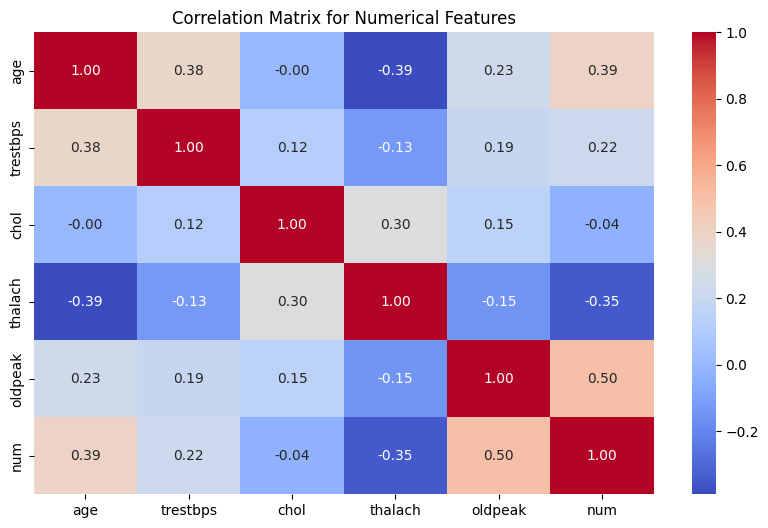

In [87]:

# Compute the correlation matrix
correlation_matrix = under_sampled_data[numerical_features].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Features')
plt.show()


In [88]:
def cramers_v(confusion_matrix):
    """Calculates Cramér's V for a given confusion matrix"""
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def calculate_cramers_v(feature, target):
    confusion_matrix = pd.crosstab(under_sampled_data[feature], under_sampled_data[target])
    return cramers_v(confusion_matrix)
    # Function to compute Cramér's V between two categorical features
def calculate_cramers_v_between_features(feature1, feature2):
    confusion_matrix = pd.crosstab(under_sampled_data[feature1], under_sampled_data[feature2])
    return cramers_v(confusion_matrix)

In [89]:

cramers_v_results = {}

for feature in categorical_features:
    cramers_v_value = calculate_cramers_v(feature, 'num')
    cramers_v_results[feature] = cramers_v_value

# Display Cramér's V results
print("\nCramér's V for Categorical Features:")
for feature, value in cramers_v_results.items():
    print(f"{feature}: {value:.2f}")


Cramér's V for Categorical Features:
sex: 0.26
cp: 0.36
fbs: 0.18
restecg: 0.21
exang: 0.38
slope: 0.31
ca: 0.41
thal: 0.41


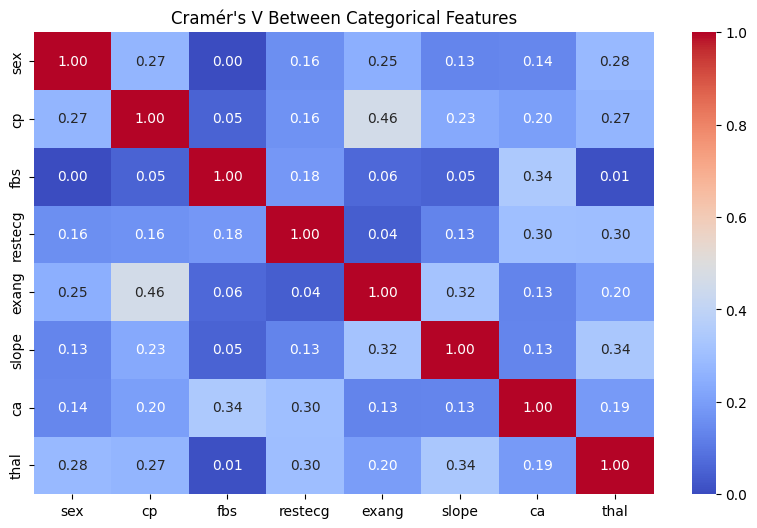

              sex        cp       fbs   restecg     exang     slope        ca  \
sex      1.000000  0.267773  0.000000  0.156702  0.246752  0.134127  0.139464   
cp       0.267773  1.000000  0.054522  0.164931  0.457488  0.233047  0.200612   
fbs      0.000000  0.054522  1.000000  0.182840  0.063762  0.052349  0.341334   
restecg  0.156702  0.164931  0.182840  1.000000  0.040146  0.132580  0.302317   
exang    0.246752  0.457488  0.063762  0.040146  1.000000  0.317724  0.128909   
slope    0.134127  0.233047  0.052349  0.132580  0.317724  1.000000  0.133707   
ca       0.139464  0.200612  0.341334  0.302317  0.128909  0.133707  1.000000   
thal     0.281322  0.267442  0.008704  0.297691  0.197470  0.335452  0.188676   

             thal  
sex      0.281322  
cp       0.267442  
fbs      0.008704  
restecg  0.297691  
exang    0.197470  
slope    0.335452  
ca       0.188676  
thal     1.000000  


In [90]:
# Create a DataFrame to store Cramér's V values between categorical features
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_features), len(categorical_features))),
                                index=categorical_features, columns=categorical_features)

# Calculate Cramér's V for each pair of categorical features
for feature1 in categorical_features:
    for feature2 in categorical_features:
        if feature1 != feature2:
            cramers_v_matrix.loc[feature1, feature2] = calculate_cramers_v_between_features(feature1, feature2)
        else:
            cramers_v_matrix.loc[feature1, feature2] = 1  # Cramér's V of a feature with itself is 1

# Display the Cramér's V matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Cramér's V Between Categorical Features")
plt.show()

# Show the raw Cramér's V matrix
print(cramers_v_matrix)

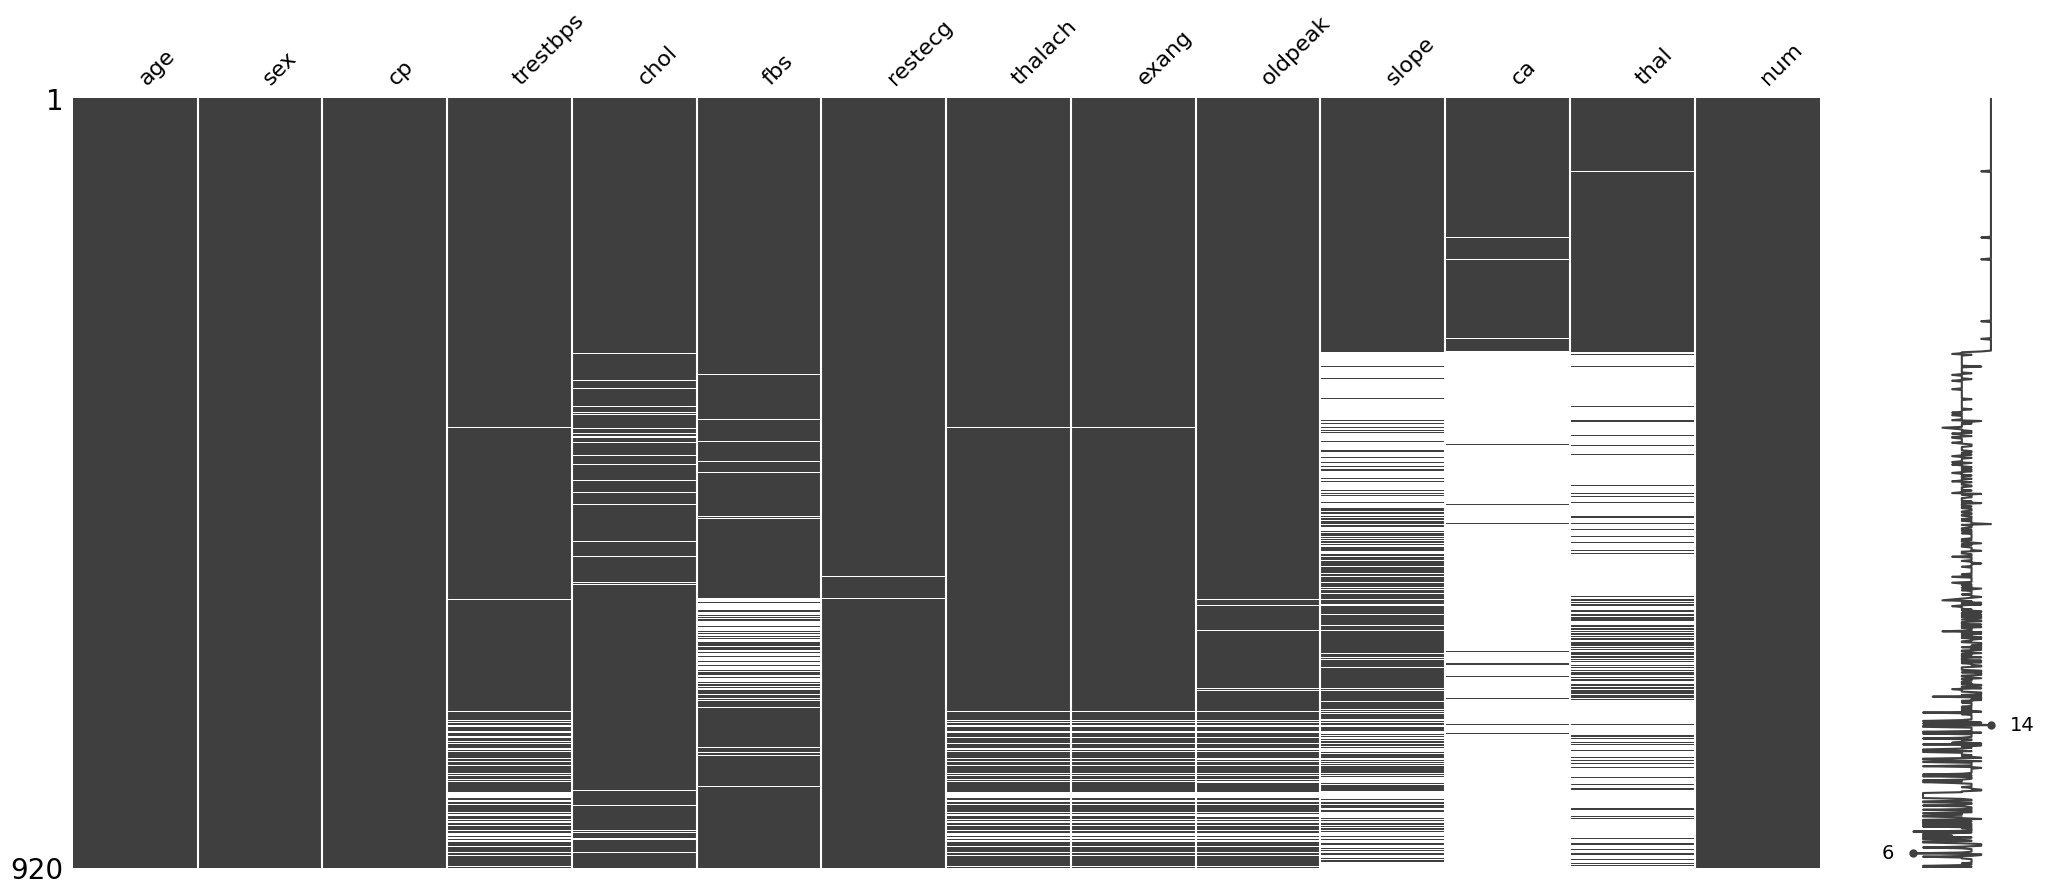

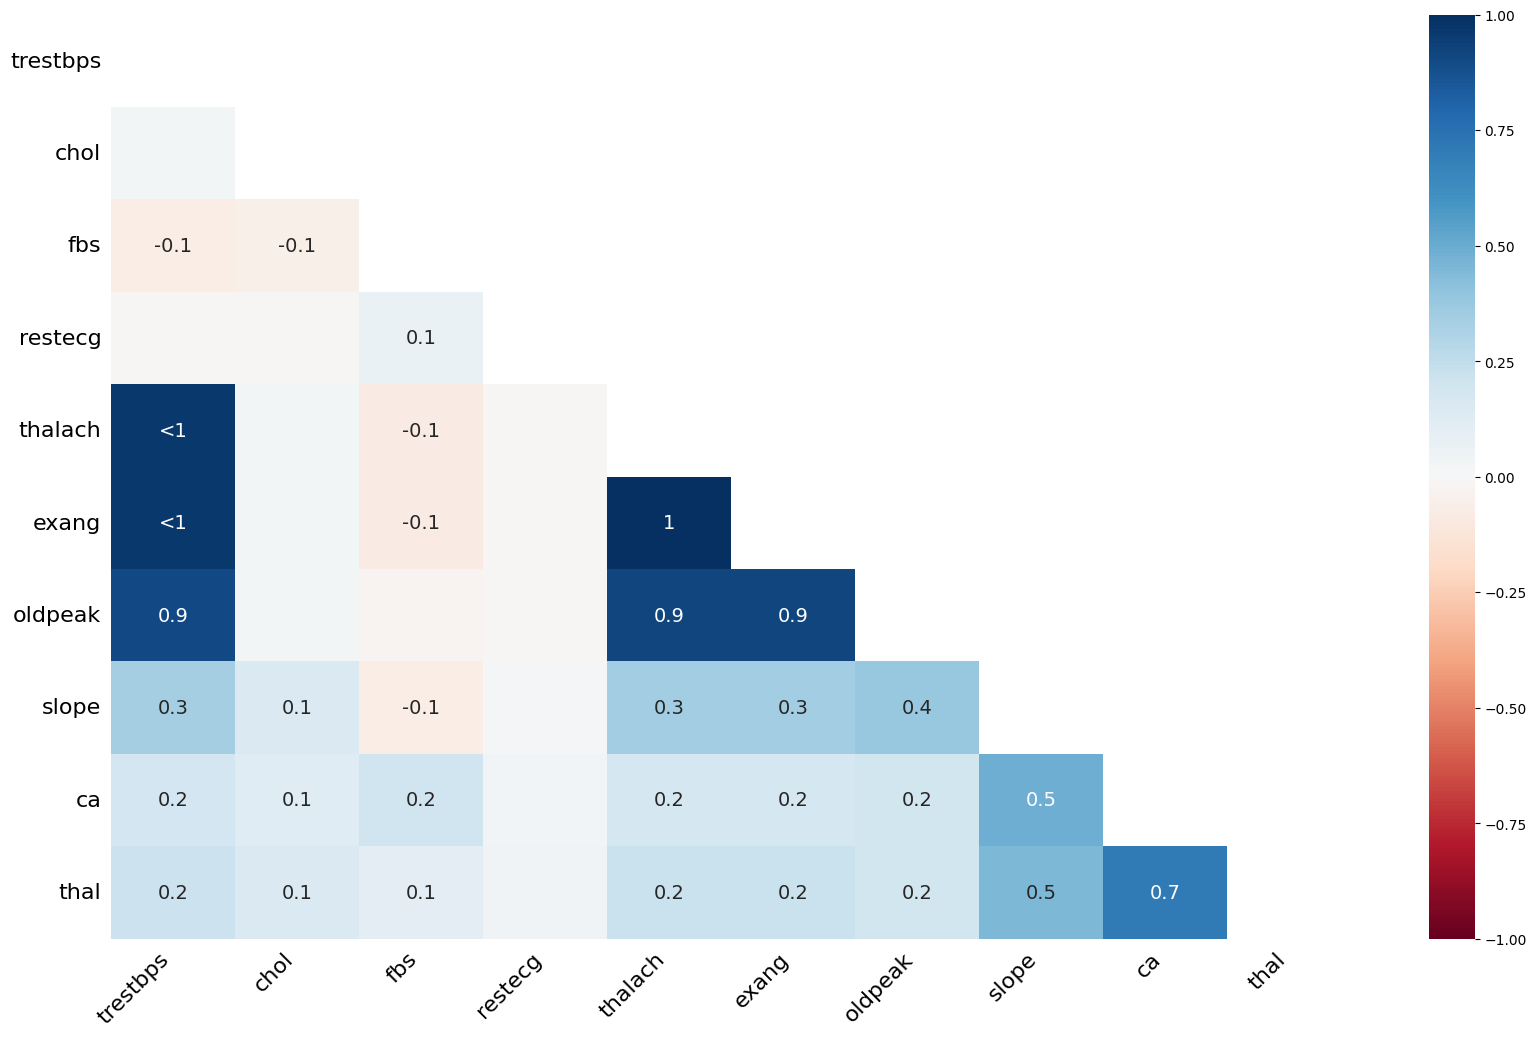

In [91]:
# Visualizing missing data patterns
msno.matrix(all_data)
plt.show()

msno.heatmap(all_data)
plt.show()

Little's test for Missing Completely At Random (MCAR)

In [92]:
# Identify variables with missing data
missing_vars = all_data.columns[all_data.isnull().any()]
print("Variables with missing data:", missing_vars.tolist())

Variables with missing data: ['trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [93]:
# Create missingness indicator variable for each missing variable
for missing_var in missing_vars:
    all_data[missing_var + '_missing'] = all_data[missing_var].isnull().astype(int)

In [94]:
mcar_results = {}

for missing_var in missing_vars:

    missing_indicator = missing_var + '_missing'
    mcar_results[missing_var] = {}

    print(f"\nAnalyzing missingness of {missing_var}")

    for other_var in all_data.columns:

        if other_var == missing_var or other_var == missing_indicator:
            continue  # Skip the missing variable itself and its missingness indicator

        # Drop rows where other_var is missing
        data = all_data[[missing_indicator, other_var]].dropna()

        if data.shape[0] < 2:
            continue  # Not enough data to perform the test

        if other_var in categorical_features:
            # Perform chi-squared test
            contingency_table = pd.crosstab(data[missing_indicator], data[other_var])
            if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
                continue  # Not enough categories to perform test
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            mcar_results[missing_var][other_var] = p

            print(f"Chi-squared test between missingness of {missing_var} and categorical variable {other_var}: p-value = {p:.4f}")

        elif other_var in numerical_features:
            # Perform t-test
            group0 = data[data[missing_indicator] == 0][other_var]
            group1 = data[data[missing_indicator] == 1][other_var]
            # Check if both groups have enough data
            if len(group0) < 2 or len(group1) < 2:
                continue
            t_stat, p = stats.ttest_ind(group0, group1, equal_var=False, nan_policy='omit')
            mcar_results[missing_var][other_var] = p

            print(f"T-test between missingness of {missing_var} and numerical variable {other_var}: p-value = {p:.4f}")


Analyzing missingness of trestbps
T-test between missingness of trestbps and numerical variable age: p-value = 0.0000
Chi-squared test between missingness of trestbps and categorical variable sex: p-value = 0.0010
Chi-squared test between missingness of trestbps and categorical variable cp: p-value = 0.1591
T-test between missingness of trestbps and numerical variable chol: p-value = 0.3669
Chi-squared test between missingness of trestbps and categorical variable fbs: p-value = 0.0000
Chi-squared test between missingness of trestbps and categorical variable restecg: p-value = 0.0000
T-test between missingness of trestbps and numerical variable thalach: p-value = 0.1243
Chi-squared test between missingness of trestbps and categorical variable exang: p-value = 0.3332
T-test between missingness of trestbps and numerical variable oldpeak: p-value = 0.0275
Chi-squared test between missingness of trestbps and categorical variable slope: p-value = 0.3994
Chi-squared test between missingness 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Chi-squared test between missingness of thalach and categorical variable sex: p-value = 0.0019
Chi-squared test between missingness of thalach and categorical variable cp: p-value = 0.1574
T-test between missingness of thalach and numerical variable chol: p-value = 0.8694
Chi-squared test between missingness of thalach and categorical variable fbs: p-value = 0.0000
Chi-squared test between missingness of thalach and categorical variable restecg: p-value = 0.0000
Chi-squared test between missingness of thalach and categorical variable slope: p-value = 0.3655
Chi-squared test between missingness of thalach and categorical variable thal: p-value = 0.2819
T-test between missingness of thalach and numerical variable num: p-value = 0.0416

Analyzing missingness of exang
T-test between missingness of exang and numerical variable age: p-value = 0.0000
Chi-squared test between missingness of exang and categorical variable sex: p-value = 0.0019
Chi-squared test between missingness of exang and 

In [95]:
# Summarize the results
for missing_var in missing_vars:
    p_values = mcar_results[missing_var]
    significant_vars = [var for var, p in p_values.items() if p < 0.05]
    if significant_vars:
        print(f"\nMissingness in '{missing_var}' is associated with variables: {significant_vars}")
        print("This suggests that the data is not MCAR.")
    else:
        print(f"\nMissingness in '{missing_var}' is not significantly associated with any observed variable.")
        print("This suggests that the data may be MCAR.")


Missingness in 'trestbps' is associated with variables: ['age', 'sex', 'fbs', 'restecg', 'oldpeak', 'num']
This suggests that the data is not MCAR.

Missingness in 'chol' is associated with variables: ['num']
This suggests that the data is not MCAR.

Missingness in 'fbs' is associated with variables: ['sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'slope', 'ca', 'num']
This suggests that the data is not MCAR.

Missingness in 'restecg' is associated with variables: ['cp']
This suggests that the data is not MCAR.

Missingness in 'thalach' is associated with variables: ['age', 'sex', 'fbs', 'restecg', 'num']
This suggests that the data is not MCAR.

Missingness in 'exang' is associated with variables: ['age', 'sex', 'fbs', 'restecg', 'num']
This suggests that the data is not MCAR.

Missingness in 'oldpeak' is associated with variables: ['age', 'sex', 'fbs', 'restecg', 'num']
This suggests that the data is not MCAR.

Missingness in 'slope' is associated with variables: ['age', 'cp

No MCAR so safe for MICE imputation

In [96]:
# Initialize data imputation before outlier removal
data_for_imputation = under_sampled_data.copy()

In [97]:
# Create a copy to avoid modifying the original data
data_encoded = data_for_imputation.copy()

all_features = data_for_imputation.columns.tolist()
data_encoded = data_for_imputation.copy()
le = LabelEncoder()

for col in categorical_features:
    data_encoded[col] = le.fit_transform(data_encoded[col].astype(str))

In [98]:
# Impute missing values using MICE
imputer = IterativeImputer(random_state=42)
data_imputed = imputer.fit_transform(data_encoded)
data_imputed = pd.DataFrame(data_imputed, columns=data_encoded.columns)
data_imputed[categorical_features] = data_imputed[categorical_features].round().astype(int)


In [99]:
# One-hot encode categorical variables
data_final = pd.get_dummies(data_imputed, columns=categorical_features, drop_first=True)

In [100]:
# Separate features and target
X = data_final.drop('num', axis=1)
y = data_final['num']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Using the Interquartile Range (IQR) Method to remove extreme anomaly

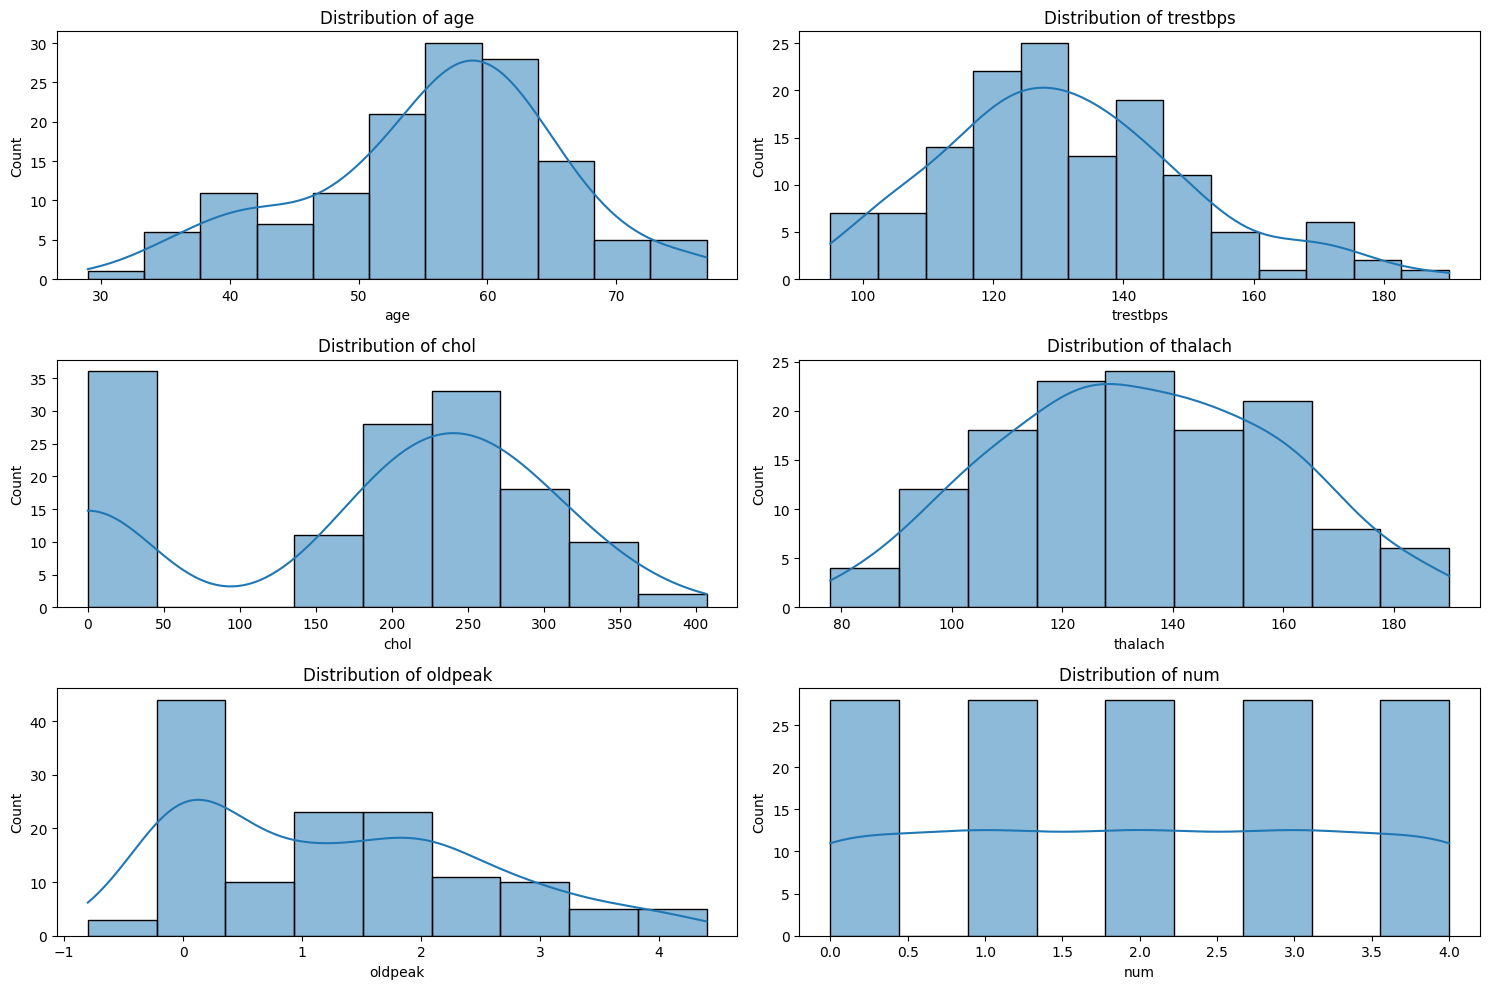

In [101]:
# Plot histograms for numerical features before imputation
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=under_sampled_data, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()



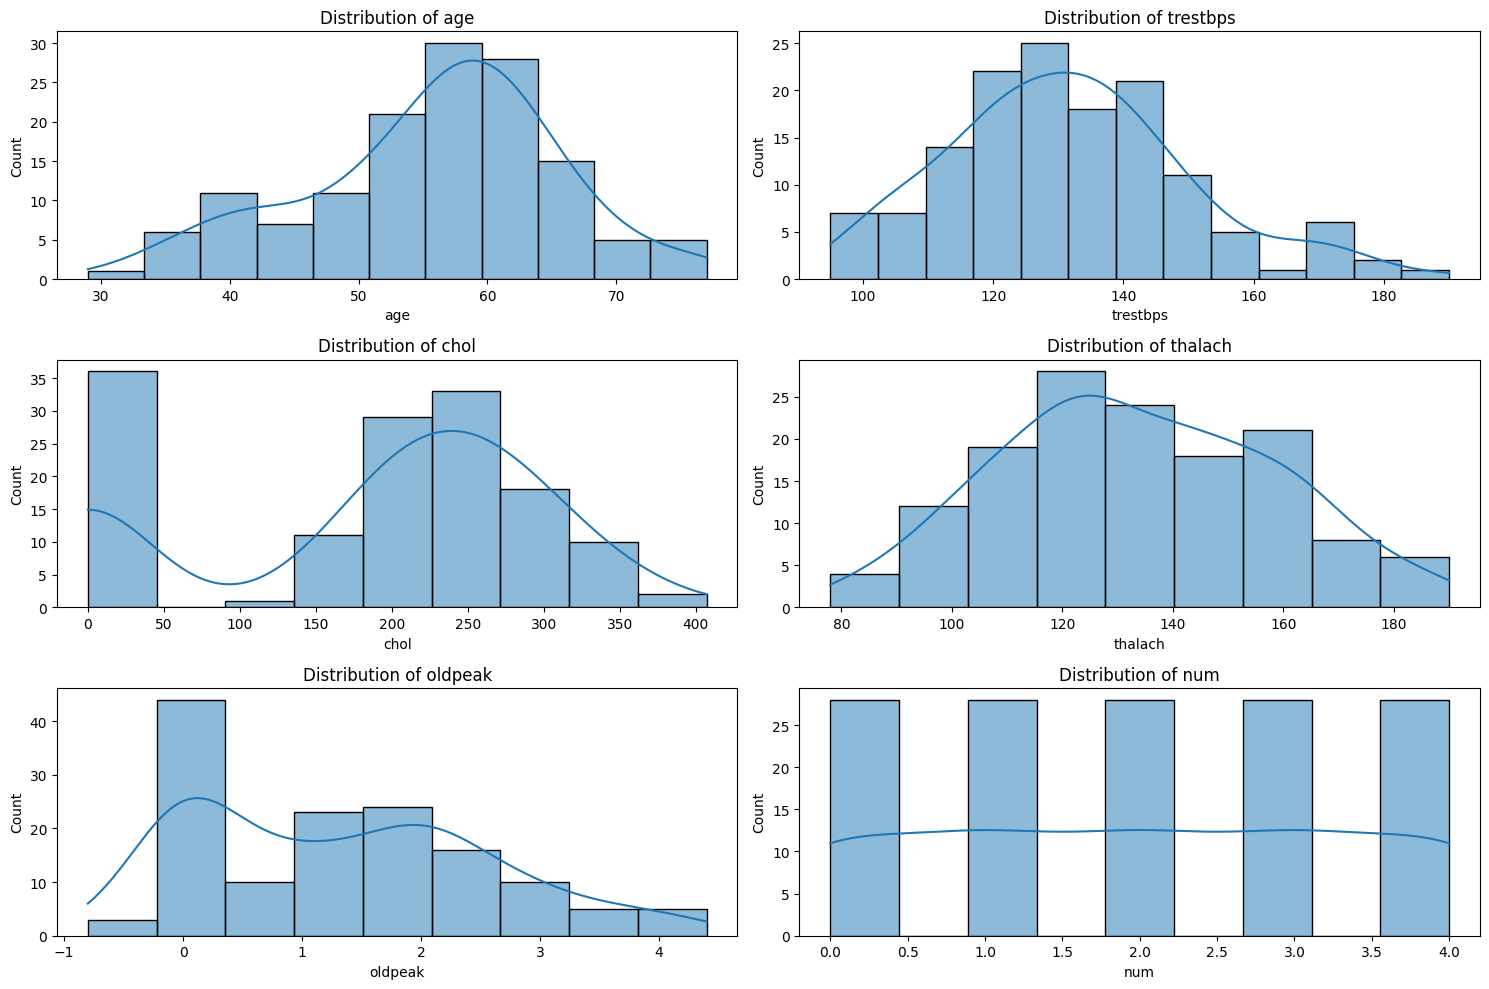

In [102]:
# Plot histograms for numerical features after imputation
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=data_imputed, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


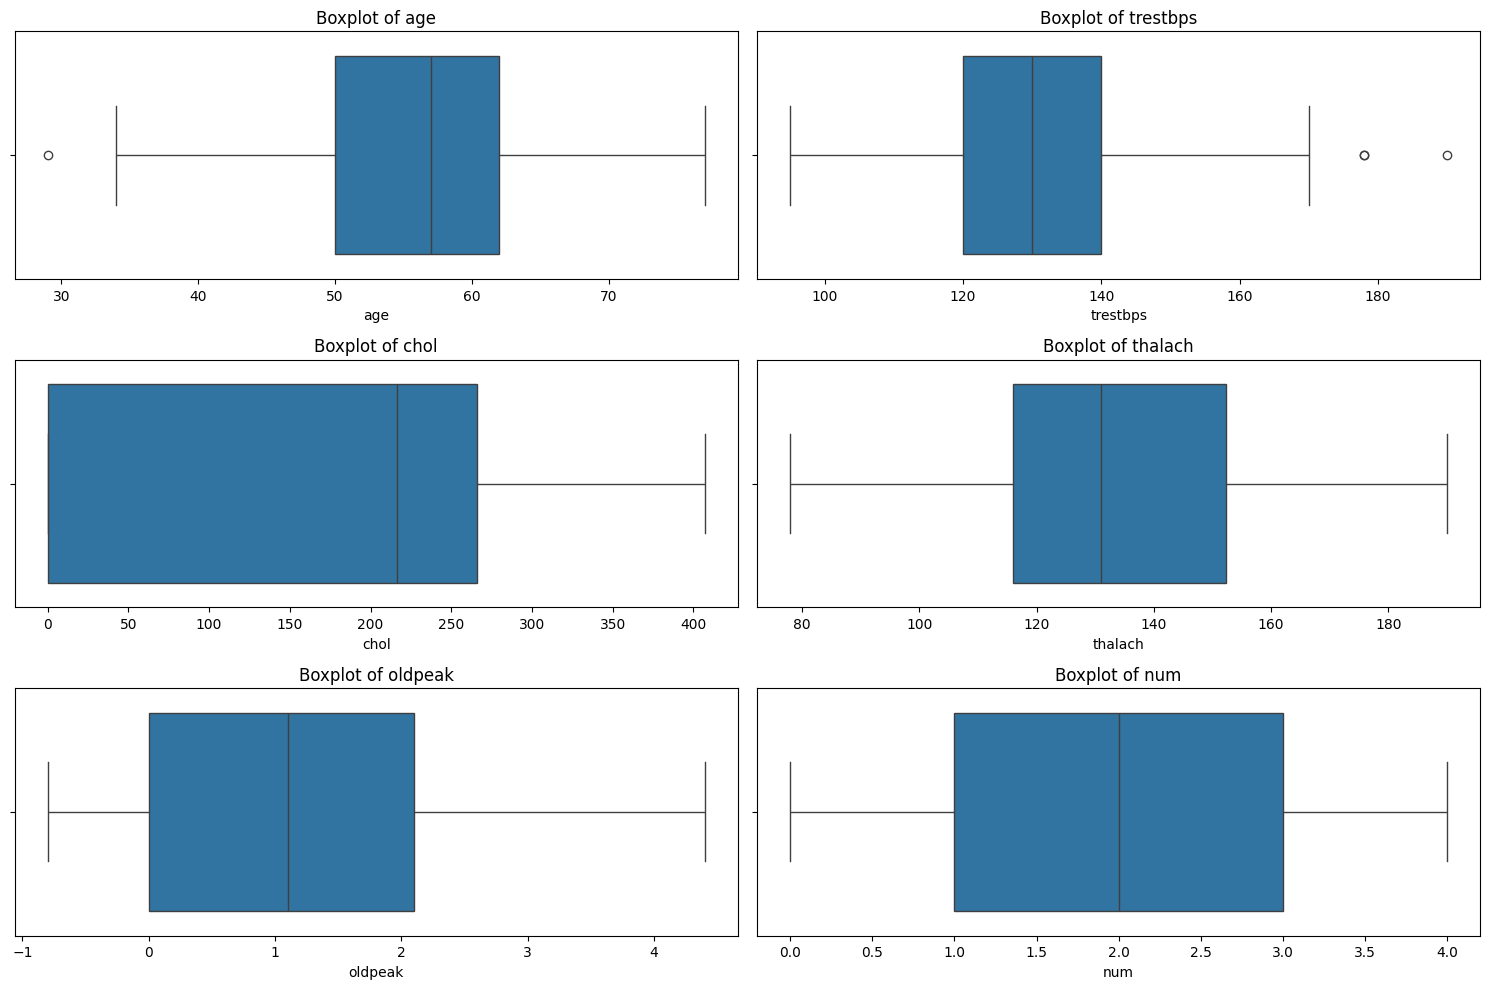

In [103]:
# Plot boxplots for numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(data=data_imputed, x=feature)
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

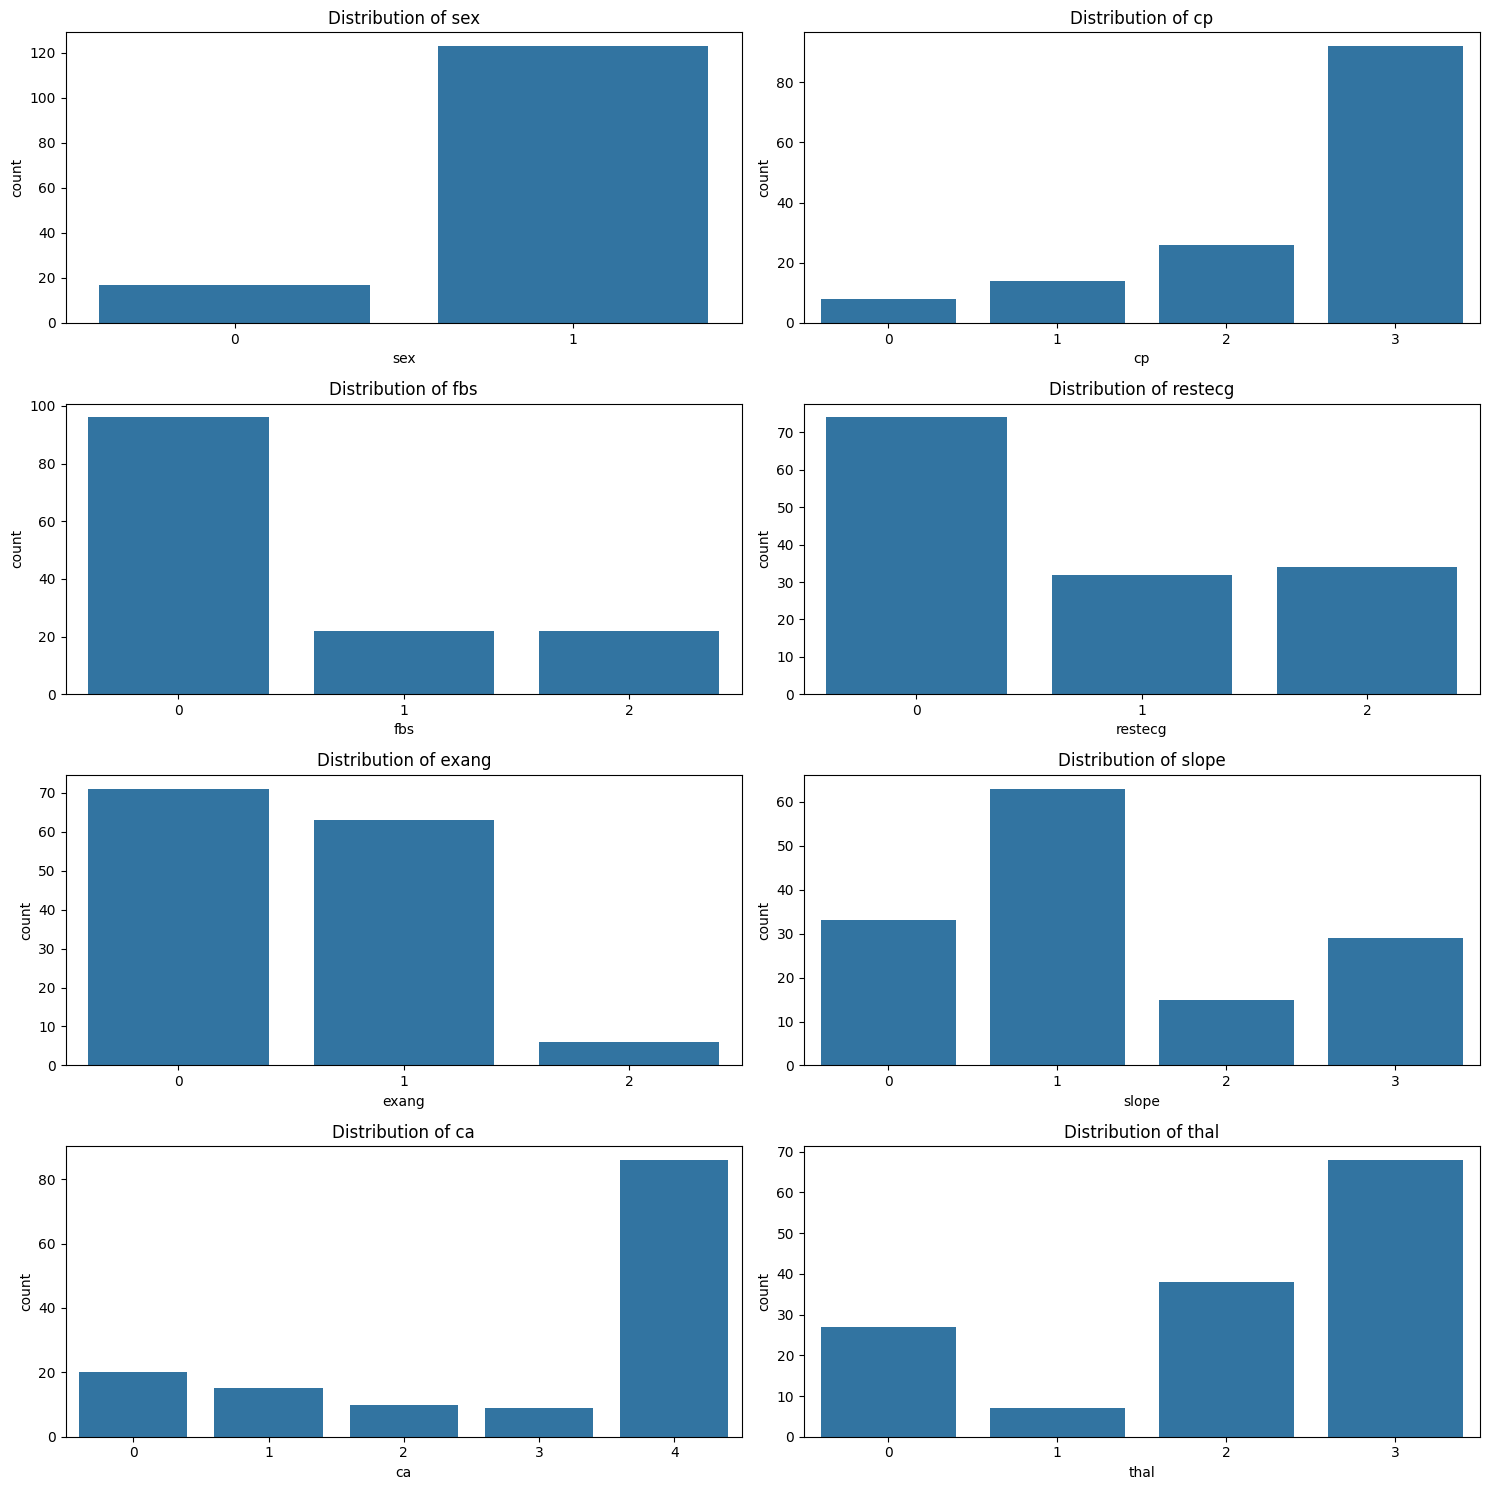

In [104]:
# Plot bar plots for categorical features
plt.figure(figsize=(15, 15))
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 2, i+1)
    sns.countplot(data=data_imputed, x=feature)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

Above also shows the reason why I didn't choose to do Independent Component Analysis (ICA), becuase this data was far from non-Gaussian distributed data

In [105]:
# List of numerical features that has enough data to do iqr
numerical_features_iqr = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [106]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df, features):
    outliers_index = set()

    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outlier indices for this feature
        outlier_list = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
        outliers_index.update(outlier_list)

        print(f"{feature}: Lower bound = {lower_bound}, Upper bound = {upper_bound}")
        print(f"Number of outliers in {feature}: {len(outlier_list)}")

    return list(outliers_index)

In [107]:
# Detect outliers
outliers = detect_outliers_iqr(data_imputed, numerical_features_iqr)

print(f"Total number of outliers detected: {len(outliers)}")

# Remove outliers from the data
data_without_outliers = data_imputed.drop(index=outliers).reset_index(drop=True)

print(f"Data shape after removing outliers: {data_without_outliers.shape}")

age: Lower bound = 32.0, Upper bound = 80.0
Number of outliers in age: 1
trestbps: Lower bound = 90.0, Upper bound = 170.0
Number of outliers in trestbps: 3
chol: Lower bound = -398.625, Upper bound = 664.375
Number of outliers in chol: 0
thalach: Lower bound = 61.60027278204892, Upper bound = 206.63983633077066
Number of outliers in thalach: 0
oldpeak: Lower bound = -3.147165730409549, Upper bound = 5.245276217349248
Number of outliers in oldpeak: 0
Total number of outliers detected: 4
Data shape after removing outliers: (136, 14)


The outliers are removed, but the imputation has taken place before their removal so the imputated data will have some of the features of the outlier. They are removed afterward in order to enhance the performance of the models

In [108]:
# This is the  preprocessed data used for three experiments
preprocessed_data = data_without_outliers.copy()

Dimensionality Reduction and Visualization Principal Component Analysis (PCA)

In [109]:
# Separate features and target variable
X = preprocessed_data.drop('num', axis=1)
y = preprocessed_data['num']

In [110]:
# Get list of all features
all_features = X.columns.tolist()

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_features)

print("Shape of data after one-hot encoding:", X_encoded.shape)

Shape of data after one-hot encoding: (136, 33)


In [111]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

Principal Component Analysis (PCA)

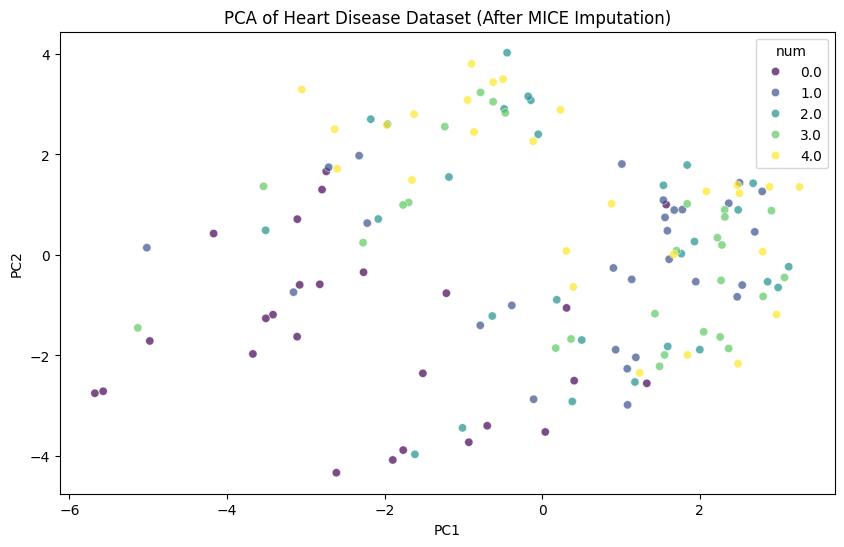

In [112]:
# Reduce to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components and target variable
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='num', palette='viridis', alpha=0.7)
plt.title('PCA of Heart Disease Dataset (After MICE Imputation)')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


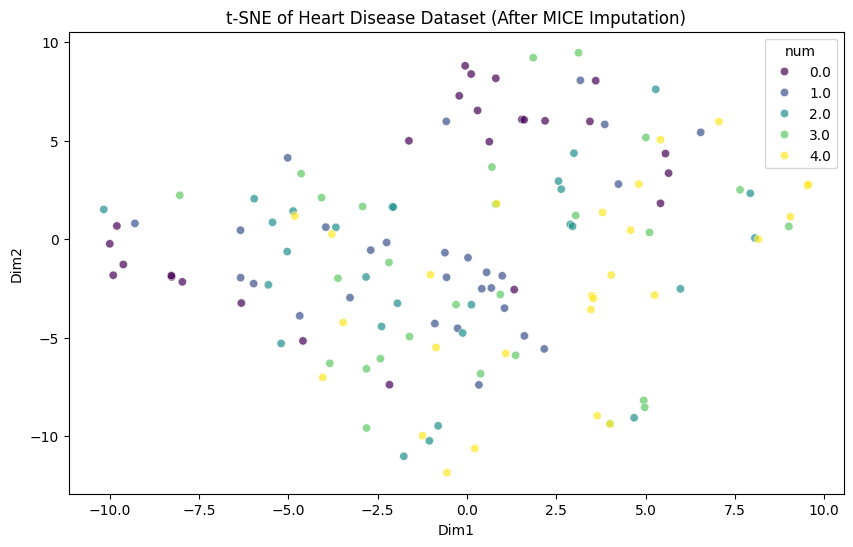

In [113]:
# t-SNE can be time-consuming; set a random state for reproducibility
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Create a DataFrame with the t-SNE components and target variable
tsne_df = pd.DataFrame(data=X_tsne, columns=['Dim1', 'Dim2'])
tsne_df = pd.concat([tsne_df, y.reset_index(drop=True)], axis=1)

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='num', palette='viridis', alpha=0.7)
plt.title('t-SNE of Heart Disease Dataset (After MICE Imputation)')
plt.show()

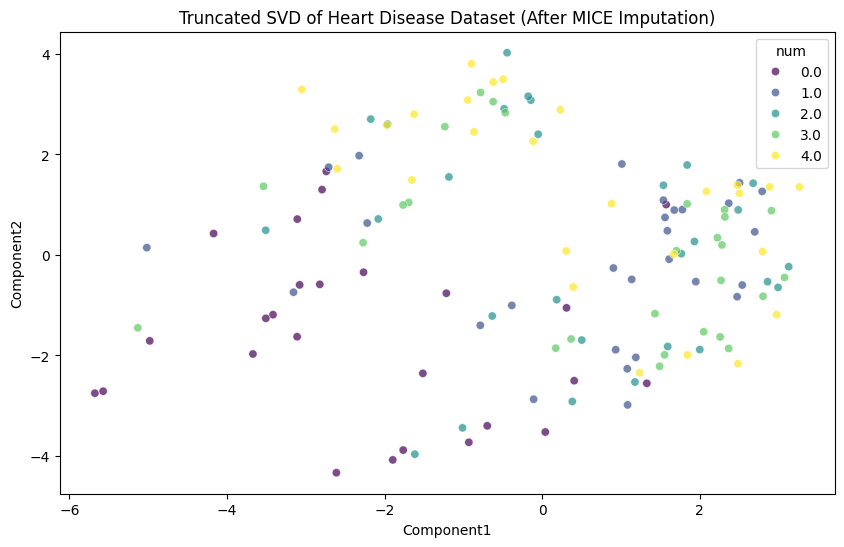

In [114]:
# Truncated SVD works on sparse matrices and is similar to PCA
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_scaled)

# Create a DataFrame with the SVD components and target variable
svd_df = pd.DataFrame(data=X_svd, columns=['Component1', 'Component2'])
svd_df = pd.concat([svd_df, y.reset_index(drop=True)], axis=1)

# Plot the Truncated SVD results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=svd_df, x='Component1', y='Component2', hue='num', palette='viridis', alpha=0.7)
plt.title('Truncated SVD of Heart Disease Dataset (After MICE Imputation)')
plt.show()

In [115]:
# Separate features and target variable
X = preprocessed_data.drop('num', axis=1)
y = preprocessed_data['num']

# Split into training and testing sets. 80 for training, 20 for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Neural Networks

In [116]:
# One-hot encode the target variable
num_classes = len(y.unique())
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

# Build the Neural Network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))                              # Hidden layer
model.add(Dense(num_classes, activation='softmax'))                  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [117]:
# Train the model
history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=50, batch_size=8)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.1807 - loss: 29.5138 - val_accuracy: 0.2195 - val_loss: 13.7874
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1888 - loss: 12.2722 - val_accuracy: 0.2195 - val_loss: 5.5577
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2462 - loss: 4.8373 - val_accuracy: 0.2195 - val_loss: 3.5876
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2947 - loss: 3.2073 - val_accuracy: 0.3171 - val_loss: 4.1006
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2200 - loss: 3.0192 - val_accuracy: 0.2439 - val_loss: 2.1567
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2893 - loss: 1.9249 - val_accuracy: 0.2927 - val_loss: 1.8671
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3478 - loss: 1.9998 - val_accuracy: 0.2683 - val_loss: 1.9309
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3491 - loss: 1.8108 - val_accuracy: 0.2927 -

In [118]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train_encoded)
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3980 - loss: 1.2415 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3051 - loss: 1.7747
Training Accuracy: 0.4211
Testing Accuracy: 0.3171


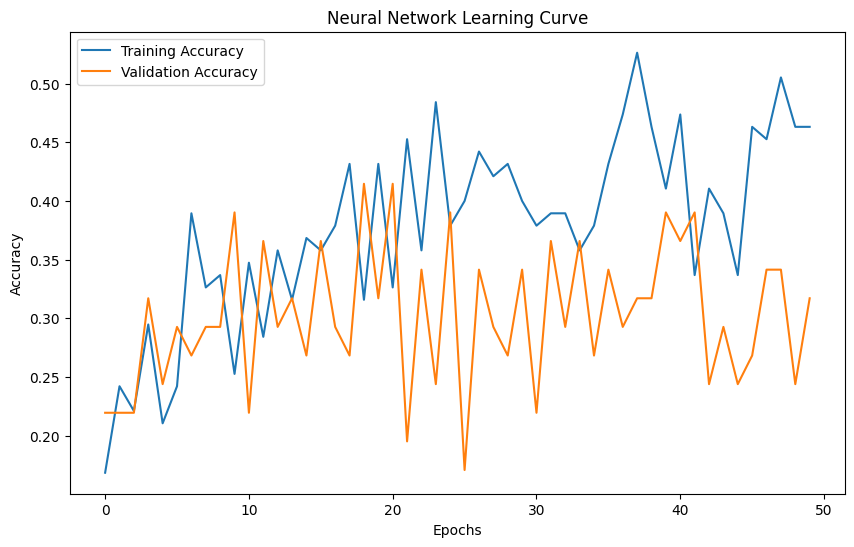

In [119]:
# Plot accuracy
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Support Vector Machines (SVM)

In [120]:
# Initialize SVM with a linear kernel
svm_linear = SVC(kernel='linear', probability=True, random_state=42)

In [121]:
# Train the model
svm_linear.fit(X_train, y_train)

# Predict on test data
y_pred_linear = svm_linear.predict(X_test)

In [122]:
# Evaluate the model
acc_linear = accuracy_score(y_test, y_pred_linear)
print(f"Linear Kernel SVM Accuracy: {acc_linear:.4f}")

Linear Kernel SVM Accuracy: 0.4146


In [123]:
# Initialize SVM with an RBF kernel
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)

# Train the model
svm_rbf.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [124]:
# Predict on test data
y_pred_rbf = svm_rbf.predict(X_test)

# Evaluate the model
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"RBF Kernel SVM Accuracy: {acc_rbf:.4f}")

RBF Kernel SVM Accuracy: 0.2195


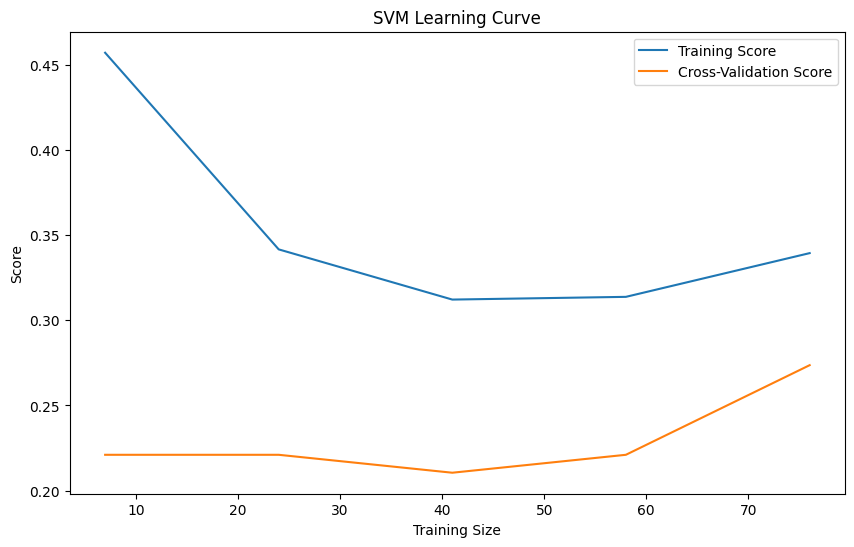

In [125]:
# Learning curve for SVM with RBF kernel
train_sizes, train_scores, test_scores = learning_curve(
    svm_rbf, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)
)

# Plot learning curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.title('SVM Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()


 k-Nearest Neighbors (k-NN)

In [126]:
# Try different values of k
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
training_accuracy = []
testing_accuracy = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Evaluate on training data
    train_acc = knn.score(X_train, y_train)
    training_accuracy.append(train_acc)

    # Evaluate on testing data
    test_acc = knn.score(X_test, y_test)
    testing_accuracy.append(test_acc)

    print(f"k={k}, Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")

k=1, Training Accuracy: 1.0000, Testing Accuracy: 0.3171
k=3, Training Accuracy: 0.5684, Testing Accuracy: 0.1707
k=5, Training Accuracy: 0.4421, Testing Accuracy: 0.2439
k=7, Training Accuracy: 0.4842, Testing Accuracy: 0.2683
k=9, Training Accuracy: 0.4526, Testing Accuracy: 0.3171
k=11, Training Accuracy: 0.4632, Testing Accuracy: 0.2927
k=13, Training Accuracy: 0.4105, Testing Accuracy: 0.2439
k=15, Training Accuracy: 0.4105, Testing Accuracy: 0.2195


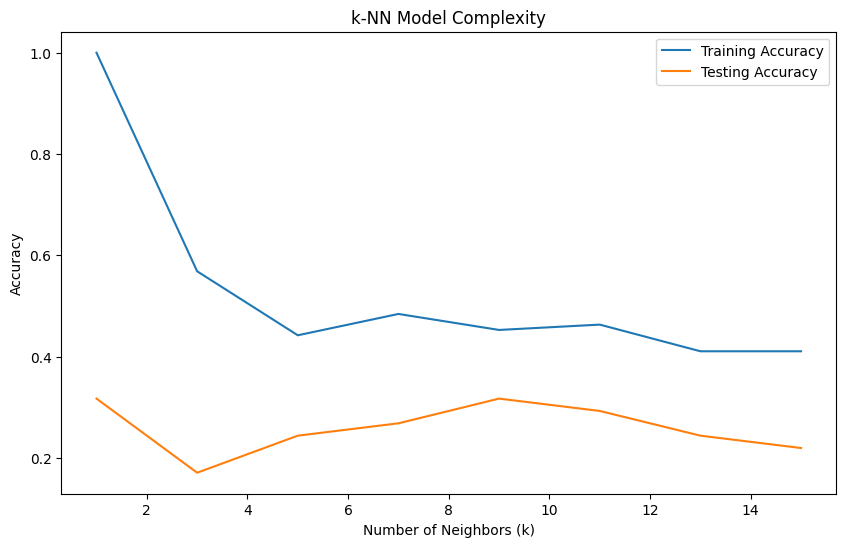

In [127]:
plt.figure(figsize=(10,6))
plt.plot(k_values, training_accuracy, label='Training Accuracy')
plt.plot(k_values, testing_accuracy, label='Testing Accuracy')
plt.title('k-NN Model Complexity')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [128]:
# Initialize a weak learner (Decision Tree with pruning)
weak_learner = DecisionTreeClassifier(max_depth=1)  # Stump

# Initialize AdaBoost
ada_boost = AdaBoostClassifier(estimator=weak_learner, n_estimators=50, random_state=42)

In [129]:
# Train the model
ada_boost.fit(X_train, y_train)

# Predict on test data
y_pred_ada = ada_boost.predict(X_test)

# Evaluate the model
acc_ada = accuracy_score(y_test, y_pred_ada)
print(f"AdaBoost Accuracy: {acc_ada:.4f}")

AdaBoost Accuracy: 0.4390


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Starting with the Original Dataset for Oversampling

In [135]:
# Concatenate all datasets
all_data = pd.concat([cleveland_data, hungarian_data, switzerland_data, long_beach_va_data], ignore_index=True)


In [136]:
print(f"Combined dataset shape: {all_data.shape}")

Combined dataset shape: (920, 14)


In [137]:
# Convert 'num' to binary target variable
all_data['target'] = all_data['num'].apply(lambda x: 1 if x > 0 else 0)
all_data = all_data.drop('num', axis=1)

In [138]:
# Check class distribution
print("Binary class distribution:")
print(all_data['target'].value_counts())


Binary class distribution:
target
1    509
0    411
Name: count, dtype: int64


In [139]:
# List of categorical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Encode categorical variables
data_encoded = all_data.copy()
le = LabelEncoder()
for col in categorical_features:
    data_encoded[col] = le.fit_transform(data_encoded[col].astype(str))


In [140]:
# Impute missing values using MICE
imputer = IterativeImputer(random_state=42)
data_imputed = imputer.fit_transform(data_encoded)
data_imputed = pd.DataFrame(data_imputed, columns=data_encoded.columns)
data_imputed[categorical_features] = data_imputed[categorical_features].round().astype(int)


In [141]:
# One-hot encode categorical variables
data_final = pd.get_dummies(data_imputed, columns=categorical_features, drop_first=True)

# Separate features and target
X = data_final.drop('target', axis=1)
y = data_final['target']


In [142]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check class distribution
print("Class distribution before SMOTE:")
print(y.value_counts())

Class distribution before SMOTE:
target
1.0    509
0.0    411
Name: count, dtype: int64


Handling Class Imbalance with SMOTE

In [143]:
# Check class distribution
print("Class distribution before SMOTE:")
print(pd.Series(y).value_counts())

Class distribution before SMOTE:
target
1.0    509
0.0    411
Name: count, dtype: int64


In [144]:
# Define evaluation function
def evaluate_model_with_smote_metrics(model, X, y):
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores = []
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        auc_roc_scores.append(roc_auc_score(y_test, y_pred_proba))
    print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Mean Precision: {np.mean(precision_scores):.4f}")
    print(f"Mean Recall: {np.mean(recall_scores):.4f}")
    print(f"Mean F1-score: {np.mean(f1_scores):.4f}")
    print(f"Mean AUC-ROC: {np.mean(auc_roc_scores):.4f}")

Re-running the Experiments

Neural Networks

In [145]:
def create_nn_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [146]:
# Wrap the model using KerasClassifier
nn_model = KerasClassifier(build_fn=create_nn_model, epochs=50, batch_size=32, verbose=0)
print("\nEvaluating Neural Network with SMOTE:")
evaluate_model_with_smote_metrics(nn_model, X_scaled, y)


Evaluating Neural Network with SMOTE:


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using 

Mean Accuracy: 0.8326
Mean Precision: 0.8451
Mean Recall: 0.8547
Mean F1-score: 0.8496
Mean AUC-ROC: 0.8837


Support Vector Machines (SVM)

In [147]:
# SVM with Linear Kernel
print("\nEvaluating SVM with Linear Kernel and SMOTE:")
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
evaluate_model_with_smote_metrics(svm_linear, X_scaled, y)


Evaluating SVM with Linear Kernel and SMOTE:
Mean Accuracy: 0.8272
Mean Precision: 0.8556
Mean Recall: 0.8272
Mean F1-score: 0.8407
Mean AUC-ROC: 0.9052


In [148]:
# SVM with RBF Kernel
print("\nEvaluating SVM with RBF Kernel and SMOTE:")
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
evaluate_model_with_smote_metrics(svm_rbf, X_scaled, y)


Evaluating SVM with RBF Kernel and SMOTE:
Mean Accuracy: 0.8370
Mean Precision: 0.8378
Mean Recall: 0.8744
Mean F1-score: 0.8555
Mean AUC-ROC: 0.9029


k-Nearest Neighbors (k-NN)

In [149]:
# k-NN
k_values = [3, 5, 7, 9]
for k in k_values:
    print(f"\nEvaluating k-NN with k={k} and SMOTE:")
    knn = KNeighborsClassifier(n_neighbors=k)
    evaluate_model_with_smote_metrics(knn, X_scaled, y)


Evaluating k-NN with k=3 and SMOTE:
Mean Accuracy: 0.7848
Mean Precision: 0.8191
Mean Recall: 0.7840
Mean F1-score: 0.8010
Mean AUC-ROC: 0.8336

Evaluating k-NN with k=5 and SMOTE:
Mean Accuracy: 0.7978
Mean Precision: 0.8314
Mean Recall: 0.7958
Mean F1-score: 0.8129
Mean AUC-ROC: 0.8636

Evaluating k-NN with k=7 and SMOTE:
Mean Accuracy: 0.8054
Mean Precision: 0.8340
Mean Recall: 0.8095
Mean F1-score: 0.8213
Mean AUC-ROC: 0.8771

Evaluating k-NN with k=9 and SMOTE:
Mean Accuracy: 0.8141
Mean Precision: 0.8406
Mean Recall: 0.8193
Mean F1-score: 0.8294
Mean AUC-ROC: 0.8818


Boosting for Decision Trees

In [151]:
# AdaBoost with Decision Trees
print("\nEvaluating AdaBoost with Decision Trees and SMOTE:")
weak_learner = DecisionTreeClassifier(max_depth=1, random_state=42)
ada_boost = AdaBoostClassifier(estimator=weak_learner, n_estimators=50, random_state=42)
evaluate_model_with_smote_metrics(ada_boost, X_scaled, y)


Evaluating AdaBoost with Decision Trees and SMOTE:


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Mean Accuracy: 0.8130
Mean Precision: 0.8427
Mean Recall: 0.8133
Mean F1-score: 0.8274
Mean AUC-ROC: 0.8702


Evaluating with Different Metrics

Hyperparameter Tuning

In [152]:
# Hyperparameter Tuning for SVM (Optional)
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [1, 0.1, 0.01],
    'classifier__kernel': ['rbf', 'linear']
}

In [153]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(probability=True, random_state=42))
])

In [154]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_scaled, y)
print("\nGrid Search Results for SVM:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()



Grid Search Results for SVM:
Best parameters: {'classifier__C': 0.1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Best cross-validation F1-score: 0.8270
